In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pyart

In [42]:
def rca_cluttermap_function(filename):
    '''Creates a clutter map (precip-free day) to be used for the RCA calculation for PPIs'''
    radar = pyart.io.cfradial.read_cfradial(filename)
    date_time = radar.time['units'].replace('seconds since ', '')
    
    # Constrain range between 1 - 5 km
    r_start_idx = np.where(radar.range['data'] < 1000.)[0][-1]+1
    r_stop_idx = np.where(radar.range['data'] > 5000.)[0][0]
    
    # Using lowest elevation angle of PPI (0.5 deg)
    sweep_start_idx = radar.sweep_start_ray_index['data'][0]
    sweep_stop_idx = radar.sweep_end_ray_index['data'][0]+1
    
    # Get variables (only the rays/gates needed)
    zh = radar.fields['reflectivity']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    zdr = radar.fields['differential_reflectivity']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    r = radar.range['data'][r_start_idx:r_stop_idx]
    theta = radar.azimuth['data'][sweep_start_idx:sweep_stop_idx]
    
    # Eliminate duplicate azimuths to maintain a total # of azimuths of 360
    if len(theta) > 360:
        diff = len(theta) - 360
        zh = np.delete(zh,-diff,axis=0)
        theta = np.delete(theta,-diff)
        
    # Arrange/sort azimuths to span 0 to 360 deg. from index 0 to 359
    sorted_idx = np.argsort(theta)
    zh = zh[sorted_idx,:]
    theta = theta[sorted_idx]
    
    # Create a fixed polar grid/array (FPG; 1 deg x 1 km) and create mask to flag clutter
    r_grid = np.array((0,1,2,3,4,5))*1000.
    theta_grid = theta
    r_matrix, theta_matrix = np.meshgrid(r_grid,theta_grid)
    clutter_flag = np.zeros((r_matrix.shape))
    
    # Set reflectivity threshold 55 dBZ
    # Flag PPI pixels in FPG box that exceed threshold
    z_thresh = 45.
    
    # Create an empty array to fill with Z from the clutter area reflectivity grid boxes (CAR)
    zh_car = np.empty((zh.shape))
    zh_car[:,:] = np.nan

    for i in range(0,len(theta_matrix[:,0])):
        for j in range(0,len(r_matrix[0,:])-1):
            if j == 0:
                clutter_flag[:,0] = np.nan
            else:
                if np.logical_or(zh[i,j*10-10] >= z_thresh, zh[i,j*10-9] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-8] >= z_thresh, zh[i,j*10-7] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-6] >= z_thresh, zh[i,j*10-5] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-4] >= z_thresh, zh[i,j*10-3] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-2] >= z_thresh, zh[i,j*10-1] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                else:
                    clutter_flag[i,j] = 0
                    
    # Calculate the PDF of the clutter area reflectivity (CAR)
    mask = np.where(np.isfinite(zh_car))  
    n,bins,patches=plt.hist(zh_car[mask],bins=105,range=(-40.,65.))
    
    # Calculate CDF of clutter area reflectivity
    cdf = np.cumsum(n)
    p = cdf/cdf[-1]*100
    
    x = np.arange(105)-40
    coeff = np.polyfit(p,x,10) # Find coefficients of 10th degree polynomial for CDF
    poly_func = np.poly1d(coeff)
    #x_poly = np.linspace(p[0],p[-1],105)
    #y_poly = poly_func(x_poly)
    
    # Find the value of reflectivity at the 95th percentile of CDF
    dbz95 = poly_func(95.)
    
    del radar
    return clutter_flag, r_matrix, theta_matrix, zh_car, date_time, n, bins, p, dbz95

/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.010003.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.084503.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.014503.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.221504.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.081504.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.063004.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.231504.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.094504.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.034504.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.220004.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.054504.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.003003.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.060004.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.024503.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1

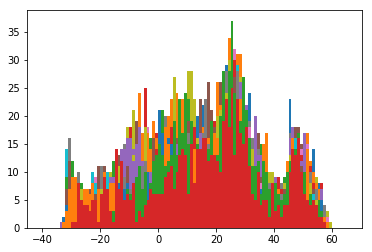

In [43]:
# Run this function on a bunch of files (try data from one day)
import os
import glob
import scipy.stats as stats
from scipy.stats import norm 

clutter_flag = []
theta = []
r = []
zh = []
dt = []
n = []
bins = []
cdf = []
p = []
dbz95 = []



for f in glob.glob(os.path.join('/home/hunzinger/data/ppi_cf/', 'corcsapr2cfrppi*.20181102.*.nc')):
    print(f)
    ClutterFlag, R, Theta, ZH, DateTime, N, Bins, P, DBZ95 = rca_cluttermap_function(f)
    
    # Put all PPI times into a list
    clutter_flag.append(ClutterFlag)
    r.append(R)
    theta.append(Theta)
    zh.append(ZH)
    dt.append(DateTime)
    n.append(N)
    bins.append(Bins)
    p.append(P)
    dbz95.append(DBZ95)

    
print(len(clutter_flag))
#print(dt[0])

48.845117983537065 0.6203147473594591
(84, 360, 6)
(360, 6)
(360, 41)
39.815862025368766


/home/hunzinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less_equal
/home/hunzinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


ValueError: x and y must have same first dimension, but have shapes (105,) and (1,)

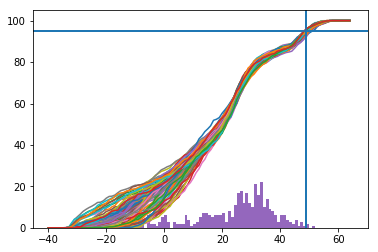

In [44]:
#print(dbz95)
#print(DBZ95)
#print(dt)
mean_dbz95 = np.nanmean(dbz95)
std_dbz95 = np.nanstd(dbz95)
print(mean_dbz95, std_dbz95)
x = np.arange(105)-40
for i in p:
    plt.plot(x,i)
    plt.axhline(95)
    plt.axvline(mean_dbz95)
    
clutter_flag = np.asarray(clutter_flag)
print(clutter_flag.shape)
PCT_on = np.sum(clutter_flag,axis=0)/len(clutter_flag[:,0,0])
#print(PCT_on)
# Mask values less than 0.5
#mask50 = PCT_on <= 0.5
mask50 = np.where(PCT_on <= 0.5)
PCT_on_50 = np.copy(PCT_on)
#PCT_on_50 = PCT_on
PCT_on_50[mask50] = np.nan
print(PCT_on_50.shape)

zh_mean = np.nanmean(zh,axis=0)
zh_50 = np.empty((zh_mean.shape))
zh_50[:,:] = np.nan
print(zh_50.shape)


for i in range(0,len(zh_50[:,0])):
    for j in range(0,len(PCT_on_50[0,:])-1):
        if np.isfinite(PCT_on_50[i,j]):
            zh_50[i,j*10-10:j*10-1] = zh_mean[i,j*10-10:j*10-1]
# Calculate the PDF of the clutter area reflectivity (CAR)
mask = np.where(np.isfinite(zh_50))  
n,bins,patches=plt.hist(zh_50[mask],bins=105,range=(-40.,65.))
    
# Calculate CDF of clutter area reflectivity
cdf = np.cumsum(n)
p = cdf/cdf[-1]*100
    
x = np.arange(105)-40
coeff = np.polyfit(p,x,10) # Find coefficients of 10th degree polynomial for CDF
poly_func = np.poly1d(coeff)
    #x_poly = np.linspace(p[0],p[-1],105)
    #y_poly = poly_func(x_poly)

    
# Find the value of reflectivity at the 95th percentile of CDF
dbz95_1 = poly_func(95.)
print(dbz95_1)

x = np.arange(105)-40
for i in p:
    plt.plot(x,i)
    plt.axhline(95)
    plt.axvline(dbz95_1)

#from netCDF4 import Dataset
#dataset = Dataset('/home/hunzinger/data/rca_cluttermap_baseline_20181102.nc',
#                  'w',format='NETCDF4_CLASSIC')
#azi = dataset.createDimension('azi', 360)
#rang = dataset.createDimension('rang', 6)
#value = dataset.createDimension('value',1)

#PCT_ON_50 = dataset.createVariable('Flagged clutter grid gates', np.float64, ('azi','rang'))
#DBZ95_BASE = dataset.createVariable('Baseline 95th reflectivity', np.float64, ('value',))

#PCT_ON_50[:,:] = PCT_on_50
#DBZ95_BASE[:] = mean_dbz95

#dataset.close()

84
[82 61 11 41  0 42 50  2 20 28 54 13 80 57 21  8 15 67 34 73 55 44 38 10
 12 40  5 35 24 19 60 83 14  4 51  1 37 79 72  7 22 59 81 75 56 78 69 18
 64 47 45 68 63 52 31 43 29 27 70 48 25 65 30 36 23 46 16 26 62 77 76 66
 71 74 32 17  9  3 53 39 58  6 33 49]
(84, 360, 41)
-33.409149169921875 59.42967987060547 18.61899185571995
18.61899185571995 379.7136580050676
-0.4278428242848449 -0.2269278736555076


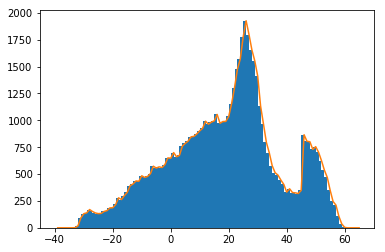

[50.]


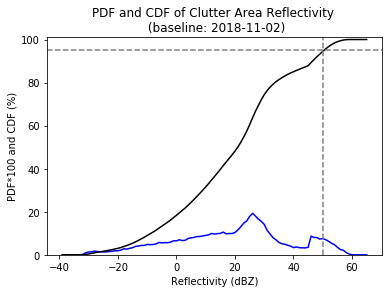

In [22]:
idx_sort = np.argsort(dt)
print(len(dt))
dt_sort = np.asarray(dt)
dt_sort = dt_sort[idx_sort]
#print(dt_sort)
#dt = dt[idx_sort]
clutter_flag_sort = np.asarray(clutter_flag)
clutter_flag_sort = clutter_flag_sort[idx_sort]
r_sort = np.asarray(r)
r_sort = r_sort[idx_sort]
zh_sort = np.asarray(zh)
zh_sort = zh_sort[idx_sort]
theta_sort = np.asarray(theta)
theta_sort = theta_sort[idx_sort]
#r = np.array(r[idx_sort])
#zh = np.array(zh[idx_sort])
#theta = np.array(theta[idx_sort])

print(idx_sort)
print(zh_sort.shape)
#print(zh.shape)
#print(dt.shape)
#print(dt)


import scipy.stats as stats
from scipy.stats import norm 
zh = np.asarray(zh)   
mask = np.where(np.isfinite(zh))  

under45 = [x for x in zh[mask] if x<=45.]
zh_min = min(zh[mask])
zh_max = max(zh[mask])
zh_mean = sum(zh[mask])/len(zh[mask])
print(zh_min, zh_max, zh_mean)

mean = np.mean(zh[mask])
var = np.var(zh[mask])
std = np.sqrt(var)
kurt = stats.kurtosis(zh[mask])
skew = stats.skew(zh[mask])

print(mean,var)
print(kurt,skew)

pdf = stats.norm.pdf(zh[mask],mean,std)
pdf_skew = stats.skewnorm.pdf(zh[mask],*stats.skewnorm.fit(zh[mask]))

n,bins,patches=plt.hist(zh[mask],bins=105,range=(-40.,65.))

cdf = np.cumsum(n)
#print(bins)
#print(n)
#print(cdf)
plt.plot(bins[1:],n)
plt.show()

p = cdf/cdf[-1]*100
select_range = np.logical_and(p>92, p<98)
diff = min(np.abs(p[select_range]-95))
dbz95 = bins[1:][np.logical_or(p==95+diff, p==95-diff)]
print(dbz95)
n_scaled = n/100
plt.plot(bins[1:],n_scaled,color='b')
plt.plot(bins[1:],p,color='k')
plt.axhline(95,linestyle='--',color='grey')
plt.axvline(dbz95,linestyle='--',color='grey')
plt.ylim(0,101)
plt.ylabel('PDF*100 and CDF (%)')
plt.xlabel('Reflectivity (dBZ)')
plt.title('PDF and CDF of Clutter Area Reflectivity \n (baseline: 2018-11-02)')
plt.show()



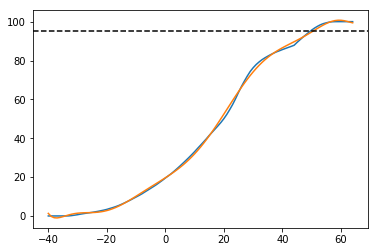

48.84968553984443


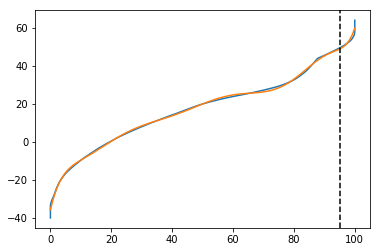

In [261]:
#plt.plot(p)
x = np.arange(105)-40
co = np.polyfit(x,p,10)
z = np.poly1d(co)
#print(z)
x_new = np.linspace(x[0], x[-1], 105)
y_new = z(x_new)

plt.plot(x,p)
plt.plot(x_new,y_new)
plt.axhline(95,color='k',linestyle='--')
plt.show()

#print(y_new)
#print(x_new)

co2 = np.polyfit(p,x,10)
z2 = np.poly1d(co2)
#print(z2)
x2 = np.linspace(p[0],p[-1],105)
y2 = z2(x2)

plt.plot(p,x)
plt.plot(x2,y2)
plt.axvline(95,linestyle='--',color='k')

dbz95 = z2(95)
print(dbz95)
#plt.plot(x,y,'o', x_new, y_new)
#x = np.arange(105)*0.01-400000
#y = co[0] + co[1]*x + co[2]*x**2 + co[3]*x**3 + co[4]*x**4 + co[5]*x**5 + co[6]*x**6 + co[7]+x**7
#plt.plot(x,y)

In [53]:
clutter_flag = np.asarray(clutter_flag)
print(clutter_flag.shape)
PCT_on = np.sum(clutter_flag,axis=0)/len(clutter_flag[:,0,0])
print(PCT_on)
# Mask values less than 0.5
mask50 = PCT_on <= 0.5
mask50 = np.where(PCT_on <= 0.5)
PCT_on_50 = np.copy(PCT_on)
#PCT_on_50 = PCT_on
PCT_on_50[mask50] = np.nan


(84, 360, 6)
[[       nan 0.         0.         0.         0.         0.        ]
 [       nan 0.         0.         0.         0.         0.        ]
 [       nan 0.         0.         0.         0.         0.        ]
 ...
 [       nan 0.         0.         0.         0.         0.        ]
 [       nan 0.         0.         0.         0.         0.        ]
 [       nan 0.01190476 0.         0.         0.         0.        ]]


/home/hunzinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/home/hunzinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


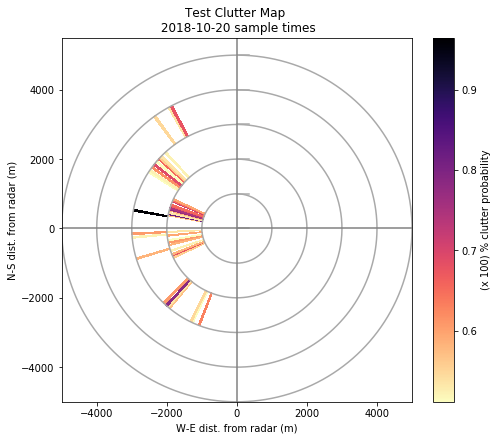

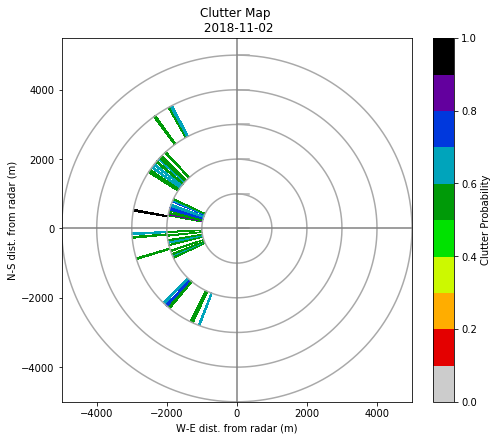

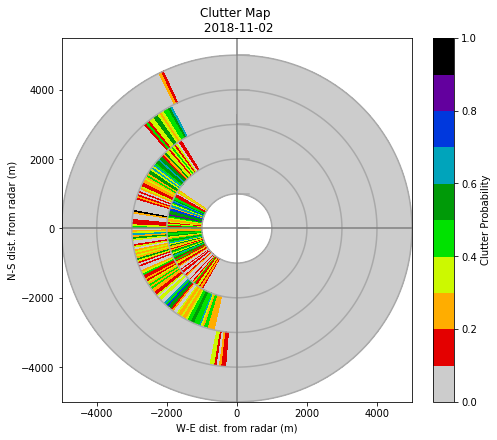

In [54]:
#import seaborn as sns
#sns.set()
from matplotlib.colors import BoundaryNorm

# Convert to cartesian coords to plot
x = (r[0]*np.sin(theta[0]*np.pi/180.))
y = (r[0]*np.cos(theta[0]*np.pi/180.))
levels = np.arange(6)/10+0.5
levels = np.arange(11)/10

fig,ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-5000,5000,color='grey')
ax1.axhline(0,-5000,5000,color='grey')

cluttermap = ax1.pcolormesh(x,y,PCT_on_50,
                           cmap=plt.cm.magma_r)
                           #vmin=0.5, vmax=1.0)#,levels)
#cluttermap = ax1.contourf(x,y,PCT_on,levels)
ax1.set_title('Test Clutter Map \n 2018-10-20 sample times')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')
cbar = fig.colorbar(cluttermap)
cbar.ax.set_ylabel('(x 100) % clutter probability')



# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('nipy_spectral_r')
#gist_stern_r, magma_r, terrain, gist_ncar,nipy_spectral
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-5000,5000,color='grey')
ax1.axhline(0,-5000,5000,color='grey')
im = ax1.pcolormesh(x, y, PCT_on_50, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel('Clutter Probability')
ax1.set_title('Clutter Map \n 2018-11-02')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')

plt.show()

fig, ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-5000,5000,color='grey')
ax1.axhline(0,-5000,5000,color='grey')
im = ax1.pcolormesh(x, y, PCT_on, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel('Clutter Probability')
ax1.set_title('Clutter Map \n 2018-11-02')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')

plt.show()